# Transformer LM

Somewhat basic implemention of transformer model

In [2]:
#| default_exp models.transformer

In [3]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [4]:
#| export

# torch
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.optim import SGD
from torchtext.vocab import vocab

# hf
import datasets

# data 
import pandas as pd
import numpy as np

# ui
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# python
from typing import Dict, List, Tuple, Optional, Set
from collections import Counter, OrderedDict
from dataclasses import dataclass, asdict
from plum import dispatch

# nimrod
from nimrod.models.lm import Vocab

## Data formatting
- https://buomsoo-kim.github.io/attention/2020/04/21/Attention-mechanism-19.md/


In [5]:
dataset = datasets.load_dataset('wikitext', 'wikitext-2-raw-v1')

Found cached dataset wikitext (/home/syl20/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
print(dataset['train'][88])

{'text': ' This ammunition , and that which I brought with me , was rapidly prepared for use at the Laboratory established at the Little Rock Arsenal for that purpose . As illustrating as the pitiful scarcity of material in the country , the fact may be stated that it was found necessary to use public documents of the State Library for cartridge paper . Gunsmiths were employed or conscripted , tools purchased or impressed , and the repair of the damaged guns I brought with me and about an equal number found at Little Rock commenced at once . But , after inspecting the work and observing the spirit of the men I decided that a garrison 500 strong could hold out against Fitch and that I would lead the remainder - about 1500 - to Gen \'l Rust as soon as shotguns and rifles could be obtained from Little Rock instead of pikes and lances , with which most of them were armed . Two days elapsed before the change could be effected . " \n'}


In [18]:
# read unstructured text into pd
df = pd.read_fwf('../data/en/tiny_shakespeare.txt', header=None)
print("Dataframe: ", df.head(2))
sentences = df[0].tolist()
print("List: ", sentences[:2])
v = Vocab(sentences)
print("Vocab: ", len(v), ''.join(v.vocabulary))

Dataframe:                                                 0
0                                 First Citizen:
1  Before we proceed any further, hear me speak.
List:  ['First Citizen:', 'Before we proceed any further, hear me speak.']
Vocab:  68  !$&',-.3:;<bos><eos><pad><unk>?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [19]:
# squash list of sentences into one large list of characters
data = []
for line in sentences:
    data.extend(line + ' ')
print(data[:100])


['F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', ' ', 'B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', ' ', 'A', 'l', 'l', ':', ' ', 'S', 'p', 'e', 'a', 'k', ',', ' ', 's', 'p', 'e', 'a', 'k', '.', ' ', 'F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', ' ', 'Y', 'o', 'u', ' ', 'a']


In [22]:
n = len(data)
train = data[:int(n*0.9)]
val = data[int(n*0.9):]
print(val[:25])


['e', ' ', 'b', 'a', 'r', 'e', '-', 'f', 'o', 'o', 't', ' ', 'o', 'n', ' ', 'h', 'e', 'r', ' ', 'w', 'e', 'd', 'd', 'i', 'n']


In [24]:
context_length = 3
x = data[:context_length]
y = data[1:context_length+1]
print(x, y)
for t in range(context_length):
    context = x[:t+1]
    target = y[t]
    print(context, target)

['F', 'i', 'r'] ['i', 'r', 's']
['F'] i
['F', 'i'] r
['F', 'i', 'r'] s


In [26]:
ids = v.stoi(data)


[52, 13, 11, 10, 6, 4, 40, 13, 6, 13]


In [28]:
print(ids[:10])
print(v.itos(ids[:10]))

[52, 13, 11, 10, 6, 4, 40, 13, 6, 13]
['F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i']


In [120]:
def get_random_batch(token_sequence, context_length, batch_size, device='cuda'):
    ix = torch.randint(len(token_sequence) - context_length, (batch_size,)) # max index is (L - context_length)
    x = torch.stack([token_sequence[i:i+context_length] for i in ix])
    y = torch.stack([token_sequence[i+1:i+1+context_length] for i in ix])
    return (x.to(device),y.to(device))

In [121]:
context_length = 10
batch_size = 8
x, y = get_random_batch(torch.LongTensor(ids), context_length, batch_size)
print(f'Batches X: {x.shape}, Y: {y.shape}')
for i in range(batch_size):
    # v.itos(int(x[i]))
    print('X: ', [v.itos(int(el)) for el in x[i]])
    print('Y: ', [v.itos(int(el)) for el in y[i]])


Batches X: torch.Size([8, 10]), Y: torch.Size([8, 10])
X:  ['e', 'e', 'p', 's', ' ', 'i', 'n', ' ', 'C', 'a']
Y:  ['e', 'p', 's', ' ', 'i', 'n', ' ', 'C', 'a', 'p']
X:  ['e', ' ', 'a', 's', ' ', 'f', 'r', 'e', 'e', 'l']
Y:  [' ', 'a', 's', ' ', 'f', 'r', 'e', 'e', 'l', 'y']
X:  ['e', "'", 's', ' ', 'n', 'o', ' ', 'v', 'i', 'r']
Y:  ["'", 's', ' ', 'n', 'o', ' ', 'v', 'i', 'r', 't']
X:  ['e', 's', 's', 'i', 'o', 'n', ' ', 'l', 'i', 'k']
Y:  ['s', 's', 'i', 'o', 'n', ' ', 'l', 'i', 'k', 'e']
X:  ['n', ' ', 'l', 'u', 's', 't', ' ', 't', 'h', 'a']
Y:  [' ', 'l', 'u', 's', 't', ' ', 't', 'h', 'a', 'n']
X:  ['f', 'u', 'l', 'l', 'y', ' ', 'A', 'b', 'o', 'u']
Y:  ['u', 'l', 'l', 'y', ' ', 'A', 'b', 'o', 'u', 't']
X:  ['o', 'u', 's', 'a', 'n', 'd', ' ', 'f', 'l', 'a']
Y:  ['u', 's', 'a', 'n', 'd', ' ', 'f', 'l', 'a', 't']
X:  ['e', 'l', 'l', 'o', 'w', ' ', 'w', 'i', 'l', 'l']
Y:  ['l', 'l', 'o', 'w', ' ', 'w', 'i', 'l', 'l', ' ']


## Attention

In [ ]:
#| export

class AttentionHead(nn.Module):
    """ self attention head """
    def __init__(self, n_embd, head_size, block_size, dropout):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [87]:
vocab_size = 10
batch_size = 5
embed_dim = 20
context_size = 8
dropout = 0.2
head_size = 16
# embedded input (float)
x = torch.randn(batch_size, context_size, embed_dim) #(B,T,C)
print(x.shape)
att = AttentionHead(embed_dim, head_size, context_size, dropout)
xx = att(x)
print(xx.shape)

torch.Size([5, 8, 20])
torch.Size([5, 8, 16])


In [65]:
#| export

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, n_embd, block_size, dropout):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead(n_embd, head_size, block_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [89]:
num_heads = 3
multi_att = MultiHeadAttention(num_heads, head_size, embed_dim, context_size, dropout)
xxx = multi_att(x)
print(xxx.shape)

torch.Size([5, 8, 20])


## Modules

In [66]:
#| export 

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [90]:
ff = FeedFoward(embed_dim, dropout)
ff_x = ff(x)
print(ff_x.shape)

torch.Size([5, 8, 20])


In [62]:
#| export 

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, block_size, dropout):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head

        self.sa = MultiHeadAttention(n_head, head_size, n_embd, block_size, dropout)
        self.ffwd = FeedFoward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [91]:
b = Block(embed_dim, num_heads, context_length, dropout)
bb = b(x)
print(bb.shape)

torch.Size([5, 8, 20])


## GPT-like model

In [104]:
#| export

class GPTLanguageModel(nn.Module):

    def __init__(self, vocab_size, n_embd, block_size, n_head, n_layer, dropout):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.block_size = block_size
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None, device='cuda'):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -self.block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [133]:
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 1500
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
vocab_size = len(v)
m = GPTLanguageModel(vocab_size, n_embd, block_size, n_head, n_layer, dropout)

In [134]:
m = m.to(device)
x = torch.randint(vocab_size, (batch_size, block_size)).to(device)
logits, loss = m(x)
print(logits.shape)

torch.Size([64, 256, 68])


In [ ]:
# @torch.no_grad()
# def estimate_loss():
#     out = {}
#     model.eval()
#     for split in ['train', 'val']:
#         losses = torch.zeros(eval_iters)
#         for k in range(eval_iters):
#             X, Y = get_batch(split)
#             logits, loss = model(X, Y)
#             losses[k] = loss.item()
#         out[split] = losses.mean()
#     model.train()
#     return out

In [135]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)
acc_loss = []
for iter in range(max_iters):

    # sample a batch of data
    xb, yb = get_random_batch(torch.LongTensor(ids), block_size, batch_size, device=device)

    # evaluate the loss
    logits, loss = m(xb.to(device), yb.to(device))
    print(loss.item())
    acc_loss.append(loss.item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

4.237611770629883
3.668224573135376
3.5153965950012207
3.453238010406494
3.3735945224761963
3.301738977432251
3.294670581817627
3.284370183944702
3.2831122875213623
3.277216911315918
3.2383873462677
3.2362399101257324
3.232257843017578
3.2340004444122314
3.1968603134155273
3.227483034133911
3.2294533252716064
3.2520651817321777
3.2137036323547363
3.18528151512146
3.192403793334961
3.1876022815704346
3.1739635467529297
3.154836893081665
3.157893657684326
3.1191647052764893
3.0763254165649414
3.078655958175659
3.010364294052124
3.015746593475342
3.0476701259613037
3.0183606147766113
3.004340410232544
2.97774600982666
2.972032308578491
2.9110677242279053
2.952284097671509
2.901395797729492
2.89970326423645
2.8884830474853516
2.88486647605896
2.8800742626190186
2.8329224586486816
2.8124606609344482
2.82620906829834
2.8399529457092285
2.7874515056610107
2.7931418418884277
2.810406446456909
2.773569345474243
2.7823173999786377
2.747957944869995
2.7632975578308105
2.7435717582702637
2.7490098

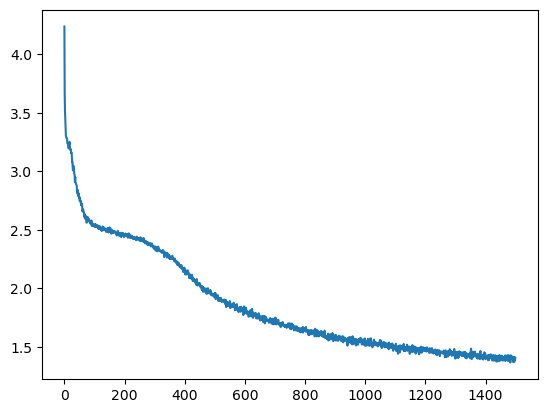

In [136]:
plt.plot(acc_loss)

In [138]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(''.join(v.itos(m.generate(context, max_new_tokens=500)[0].tolist())))

<pad>pester obyal to the wars leave. Met make prison women with teet, cendempth, To save it us, Hazarding to Loved of Norfolk, banishman: Who pity, post to Warms, And by raise? He thou saw not luttens thy spoke country. GLOUCESTER: Lord, I do rush thou an thought 'Land not Adie To allso, say, how now it thee sights; And better, true none; for neither Mantuua. I them must say, I have medicery hath we these heeld to make an it. Uncle, prospais writ, madam; whay the father said, must auffirant ye: he is


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()